In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define the model architecture (same as training)
class LungCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(LungCNN, self).__init__()
        
        # First convolution block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2)
        )
        
        # Second convolution block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )
        
        # Third convolution block
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )
        
        # Fourth convolution block
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5)
        )
        
        # Adaptive pooling
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

print("Model architecture defined ✓")

Model architecture defined ✓


In [4]:
# Load the trained model from checkpoint
checkpoint = torch.load("lung_cnn_checkpoint.pth", map_location=device)

# Initialize model and load weights
model = LungCNN(num_classes=checkpoint['num_classes']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load class names
with open("lung_class_names.pkl", "rb") as f:
    class_names = pickle.load(f)

print("=" * 60)
print("Model loaded successfully! ✓")
print("=" * 60)
print(f"\nClasses: {class_names}")
print(f"Best Validation Accuracy: {checkpoint['best_val_acc']:.4f}")
print(f"Test Accuracy: {checkpoint['test_acc']:.4f}")
print(f"Input Size: {checkpoint['input_size']}")
print("=" * 60)

C:\Users\Jatin\AppData\Local\Temp\ipykernel_24048\3796998324.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("lung_cnn_checkpoint.pth", map_locat

Model loaded successfully! ✓

Classes: ['Adenocarcinoma', 'Benign_Tissue', 'Squamous_Cell_Carcinoma']
Best Validation Accuracy: 0.9900
Test Accuracy: 0.9793
Input Size: (224, 224)


In [5]:
# Define image preprocessing (same as training)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=checkpoint['normalize_mean'],
        std=checkpoint['normalize_std']
    )
])

print("Image preprocessing pipeline created ✓")

Image preprocessing pipeline created ✓


In [6]:
# Function to predict single image
def predict_image(image_path, model, transform, class_names, device):
    """
    Predict the class of a lung histopathology image
    
    Args:
        image_path: Path to the image file
        model: Trained model
        transform: Image preprocessing transforms
        class_names: List of class names
        device: Device to run inference on
    
    Returns:
        predicted_class, confidence, all_probabilities
    """
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item()
    all_probs = probabilities.cpu().numpy()[0]
    
    return predicted_class, confidence_score, all_probs, image

print("Prediction function created ✓")

Prediction function created ✓


In [7]:
# Function to visualize prediction
def visualize_prediction(image_path, predicted_class, confidence, all_probs, class_names, original_image):
    """
    Visualize the prediction with image and probability distribution
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Display image
    axes[0].imshow(original_image)
    axes[0].axis('off')
    axes[0].set_title(f'Predicted: {predicted_class}\nConfidence: {confidence*100:.2f}%', 
                     fontsize=14, fontweight='bold', color='darkgreen')
    
    # Display probability distribution
    colors = ['#2E86AB' if i == np.argmax(all_probs) else '#A23B72' for i in range(len(class_names))]
    bars = axes[1].barh(class_names, all_probs * 100, color=colors)
    axes[1].set_xlabel('Probability (%)', fontsize=12)
    axes[1].set_title('Class Probabilities', fontsize=14, fontweight='bold')
    axes[1].set_xlim(0, 100)
    
    # Add percentage labels on bars
    for i, (bar, prob) in enumerate(zip(bars, all_probs)):
        width = bar.get_width()
        axes[1].text(width + 2, bar.get_y() + bar.get_height()/2, 
                    f'{prob*100:.2f}%', 
                    ha='left', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n" + "=" * 60)
    print("PREDICTION RESULTS")
    print("=" * 60)
    print(f"\n📊 Predicted Class: {predicted_class}")
    print(f"✓ Confidence: {confidence*100:.2f}%")
    print(f"\n📁 Image: {os.path.basename(image_path)}")
    print("\n" + "-" * 60)
    print("Class Probabilities:")
    print("-" * 60)
    for name, prob in zip(class_names, all_probs):
        print(f"{name:30s}: {prob*100:6.2f}%")
    print("=" * 60)

print("Visualization function created ✓")

Visualization function created ✓


✓ Image found: scc4.jpg

Processing image...


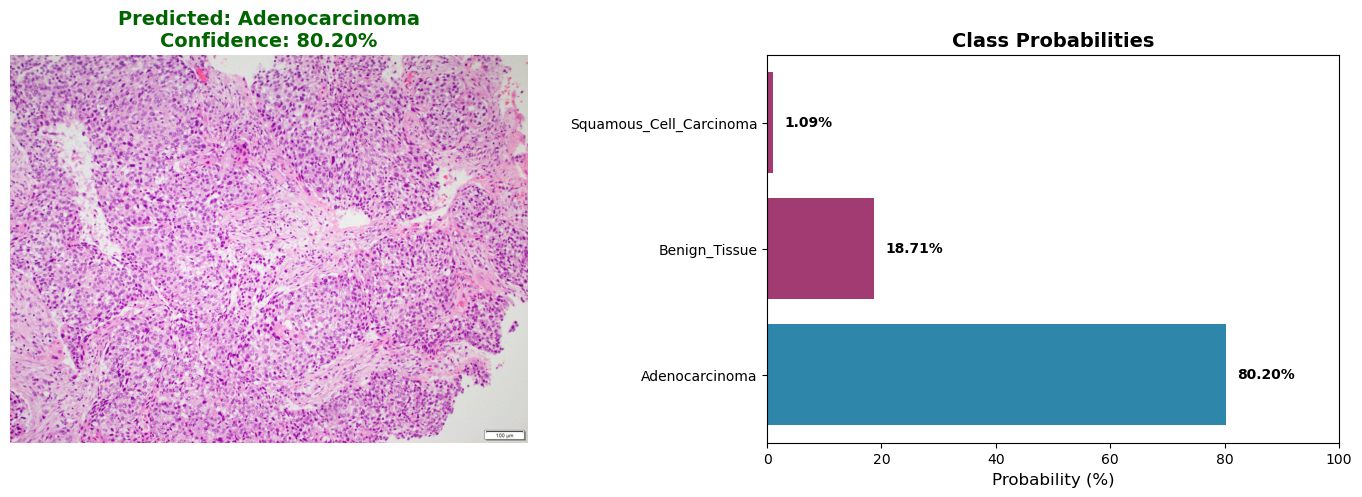


PREDICTION RESULTS

📊 Predicted Class: Adenocarcinoma
✓ Confidence: 80.20%

📁 Image: scc4.jpg

------------------------------------------------------------
Class Probabilities:
------------------------------------------------------------
Adenocarcinoma                :  80.20%
Benign_Tissue                 :  18.71%
Squamous_Cell_Carcinoma       :   1.09%


In [14]:
# ===============================================
# TEST YOUR IMAGE HERE
# ===============================================

# Replace this path with your image path
image_path = r"scc4.jpg"

# Check if file exists
if not os.path.exists(image_path):
    print(f"❌ Error: Image not found at {image_path}")
    print("\nPlease update the image_path variable with a valid path to your image.")
else:
    print(f"✓ Image found: {image_path}")
    print("\nProcessing image...")
    
    # Make prediction
    predicted_class, confidence, all_probs, original_image = predict_image(
        image_path, model, test_transform, class_names, device
    )
    
    # Visualize results
    visualize_prediction(
        image_path, predicted_class, confidence, all_probs, class_names, original_image
    )

Testing multiple images...


############################################################
IMAGE 1/3
############################################################


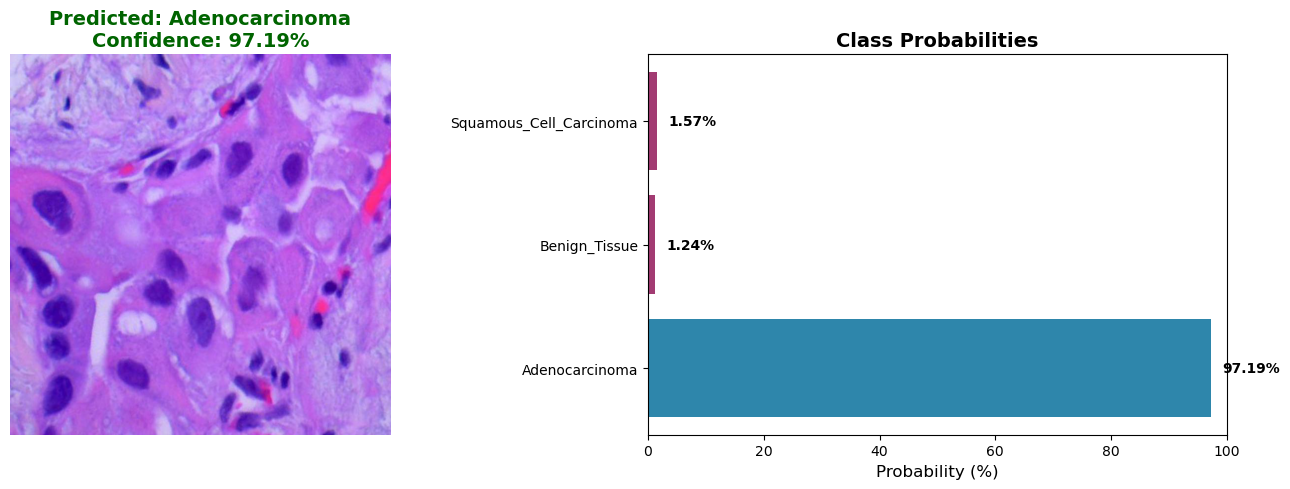


PREDICTION RESULTS

📊 Predicted Class: Adenocarcinoma
✓ Confidence: 97.19%

📁 Image: lungaca1.jpeg

------------------------------------------------------------
Class Probabilities:
------------------------------------------------------------
Adenocarcinoma                :  97.19%
Benign_Tissue                 :   1.24%
Squamous_Cell_Carcinoma       :   1.57%

############################################################
IMAGE 2/3
############################################################


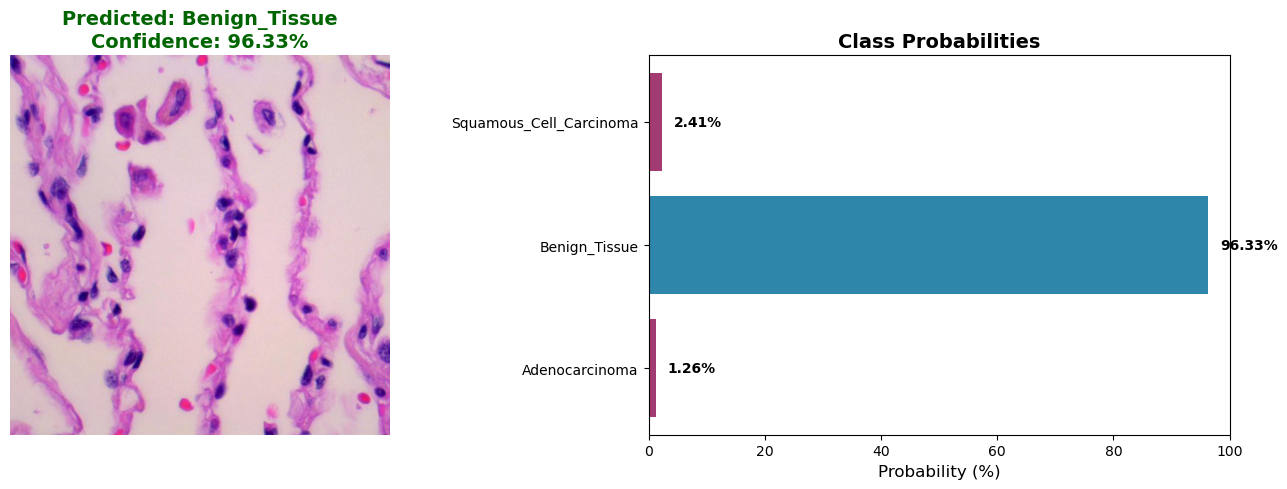


PREDICTION RESULTS

📊 Predicted Class: Benign_Tissue
✓ Confidence: 96.33%

📁 Image: lungn1.jpeg

------------------------------------------------------------
Class Probabilities:
------------------------------------------------------------
Adenocarcinoma                :   1.26%
Benign_Tissue                 :  96.33%
Squamous_Cell_Carcinoma       :   2.41%

############################################################
IMAGE 3/3
############################################################


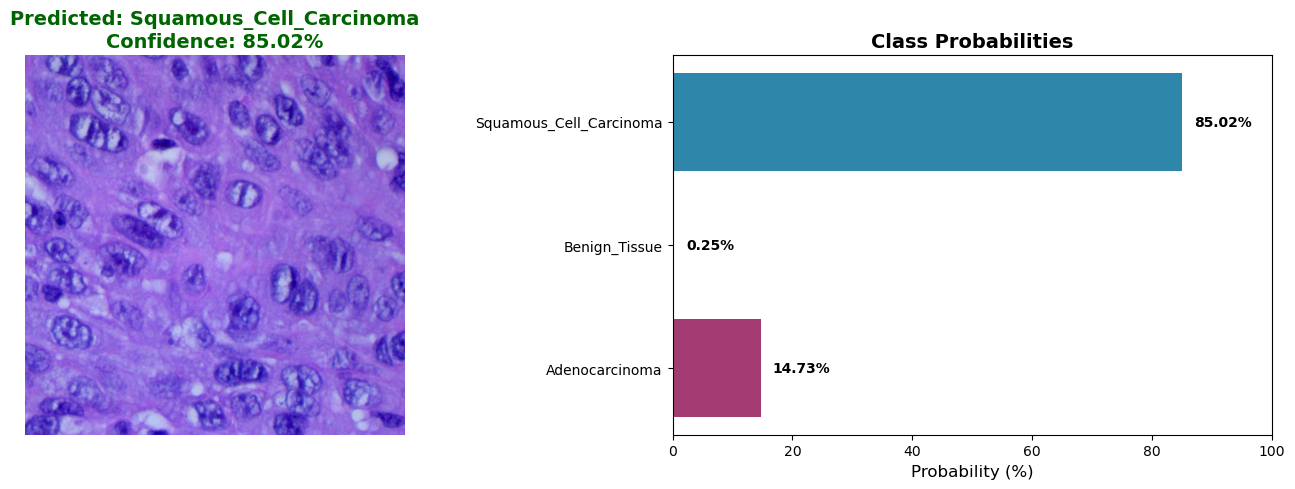


PREDICTION RESULTS

📊 Predicted Class: Squamous_Cell_Carcinoma
✓ Confidence: 85.02%

📁 Image: lungscc1.jpeg

------------------------------------------------------------
Class Probabilities:
------------------------------------------------------------
Adenocarcinoma                :  14.73%
Benign_Tissue                 :   0.25%
Squamous_Cell_Carcinoma       :  85.02%


In [15]:
# ===============================================
# TEST MULTIPLE IMAGES
# ===============================================

# List of image paths to test
image_paths = [
    r"C:\Users\Jatin\Desktop\oncogenesis\data\lungs_data\Adenocarcinoma\lungaca1.jpeg",
    r"C:\Users\Jatin\Desktop\oncogenesis\data\lungs_data\Benign_Tissue\lungn1.jpeg",
    r"C:\Users\Jatin\Desktop\oncogenesis\data\lungs_data\Squamous_Cell_Carcinoma\lungscc1.jpeg"
]

print("Testing multiple images...\n")

for i, img_path in enumerate(image_paths, 1):
    if os.path.exists(img_path):
        print(f"\n{'#'*60}")
        print(f"IMAGE {i}/{len(image_paths)}")
        print(f"{'#'*60}")
        
        predicted_class, confidence, all_probs, original_image = predict_image(
            img_path, model, test_transform, class_names, device
        )
        
        visualize_prediction(
            img_path, predicted_class, confidence, all_probs, class_names, original_image
        )
    else:
        print(f"\n❌ Image {i} not found: {img_path}")

In [ ]:
# ===============================================
# BATCH PREDICTION - Test all images in a folder
# ===============================================

def predict_folder(folder_path, model, transform, class_names, device, max_images=10):
    """
    Predict all images in a folder
    
    Args:
        folder_path: Path to folder containing images
        model: Trained model
        transform: Image preprocessing
        class_names: List of class names
        device: Device to run inference on
        max_images: Maximum number of images to process
    """
    # Get all image files
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = []
    
    for file in os.listdir(folder_path):
        if any(file.lower().endswith(ext) for ext in valid_extensions):
            image_files.append(os.path.join(folder_path, file))
    
    image_files = image_files[:max_images]
    
    if not image_files:
        print(f"❌ No image files found in {folder_path}")
        return
    
    print(f"Found {len(image_files)} images. Processing...\n")
    
    results = []
    for i, img_path in enumerate(image_files, 1):
        try:
            predicted_class, confidence, all_probs, _ = predict_image(
                img_path, model, test_transform, class_names, device
            )
            results.append({
                'image': os.path.basename(img_path),
                'prediction': predicted_class,
                'confidence': confidence * 100
            })
            print(f"✓ {i}/{len(image_files)}: {os.path.basename(img_path)} -> {predicted_class} ({confidence*100:.2f}%)")
        except Exception as e:
            print(f"❌ {i}/{len(image_files)}: Error processing {os.path.basename(img_path)}: {e}")
    
    # Print summary
    print("\n" + "=" * 80)
    print("BATCH PREDICTION SUMMARY")
    print("=" * 80)
    print(f"{'Image':<40} {'Prediction':<25} {'Confidence':<10}")
    print("-" * 80)
    for result in results:
        print(f"{result['image']:<40} {result['prediction']:<25} {result['confidence']:>6.2f}%")
    print("=" * 80)

print("Batch prediction function created ✓")

In [ ]:
# Example: Test all images in Adenocarcinoma folder
folder_path = r"C:\Users\Jatin\Desktop\oncogenesis\data\lungs_data\Adenocarcinoma"

if os.path.exists(folder_path):
    predict_folder(folder_path, model, test_transform, class_names, device, max_images=5)
else:
    print(f"❌ Folder not found: {folder_path}")
    print("\nUpdate the folder_path variable with a valid folder containing images.")